# Permutation Importance on Model M042
- Per Type, find features which do not help the model

In [2]:
import pandas as pd
import catboost
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
import numpy as np
import gc

In [3]:
fi = pd.read_csv('../temp/temp4of6_M042_0709_1336_fi_catboost_2folds_500000iter_0.1lr.csv')

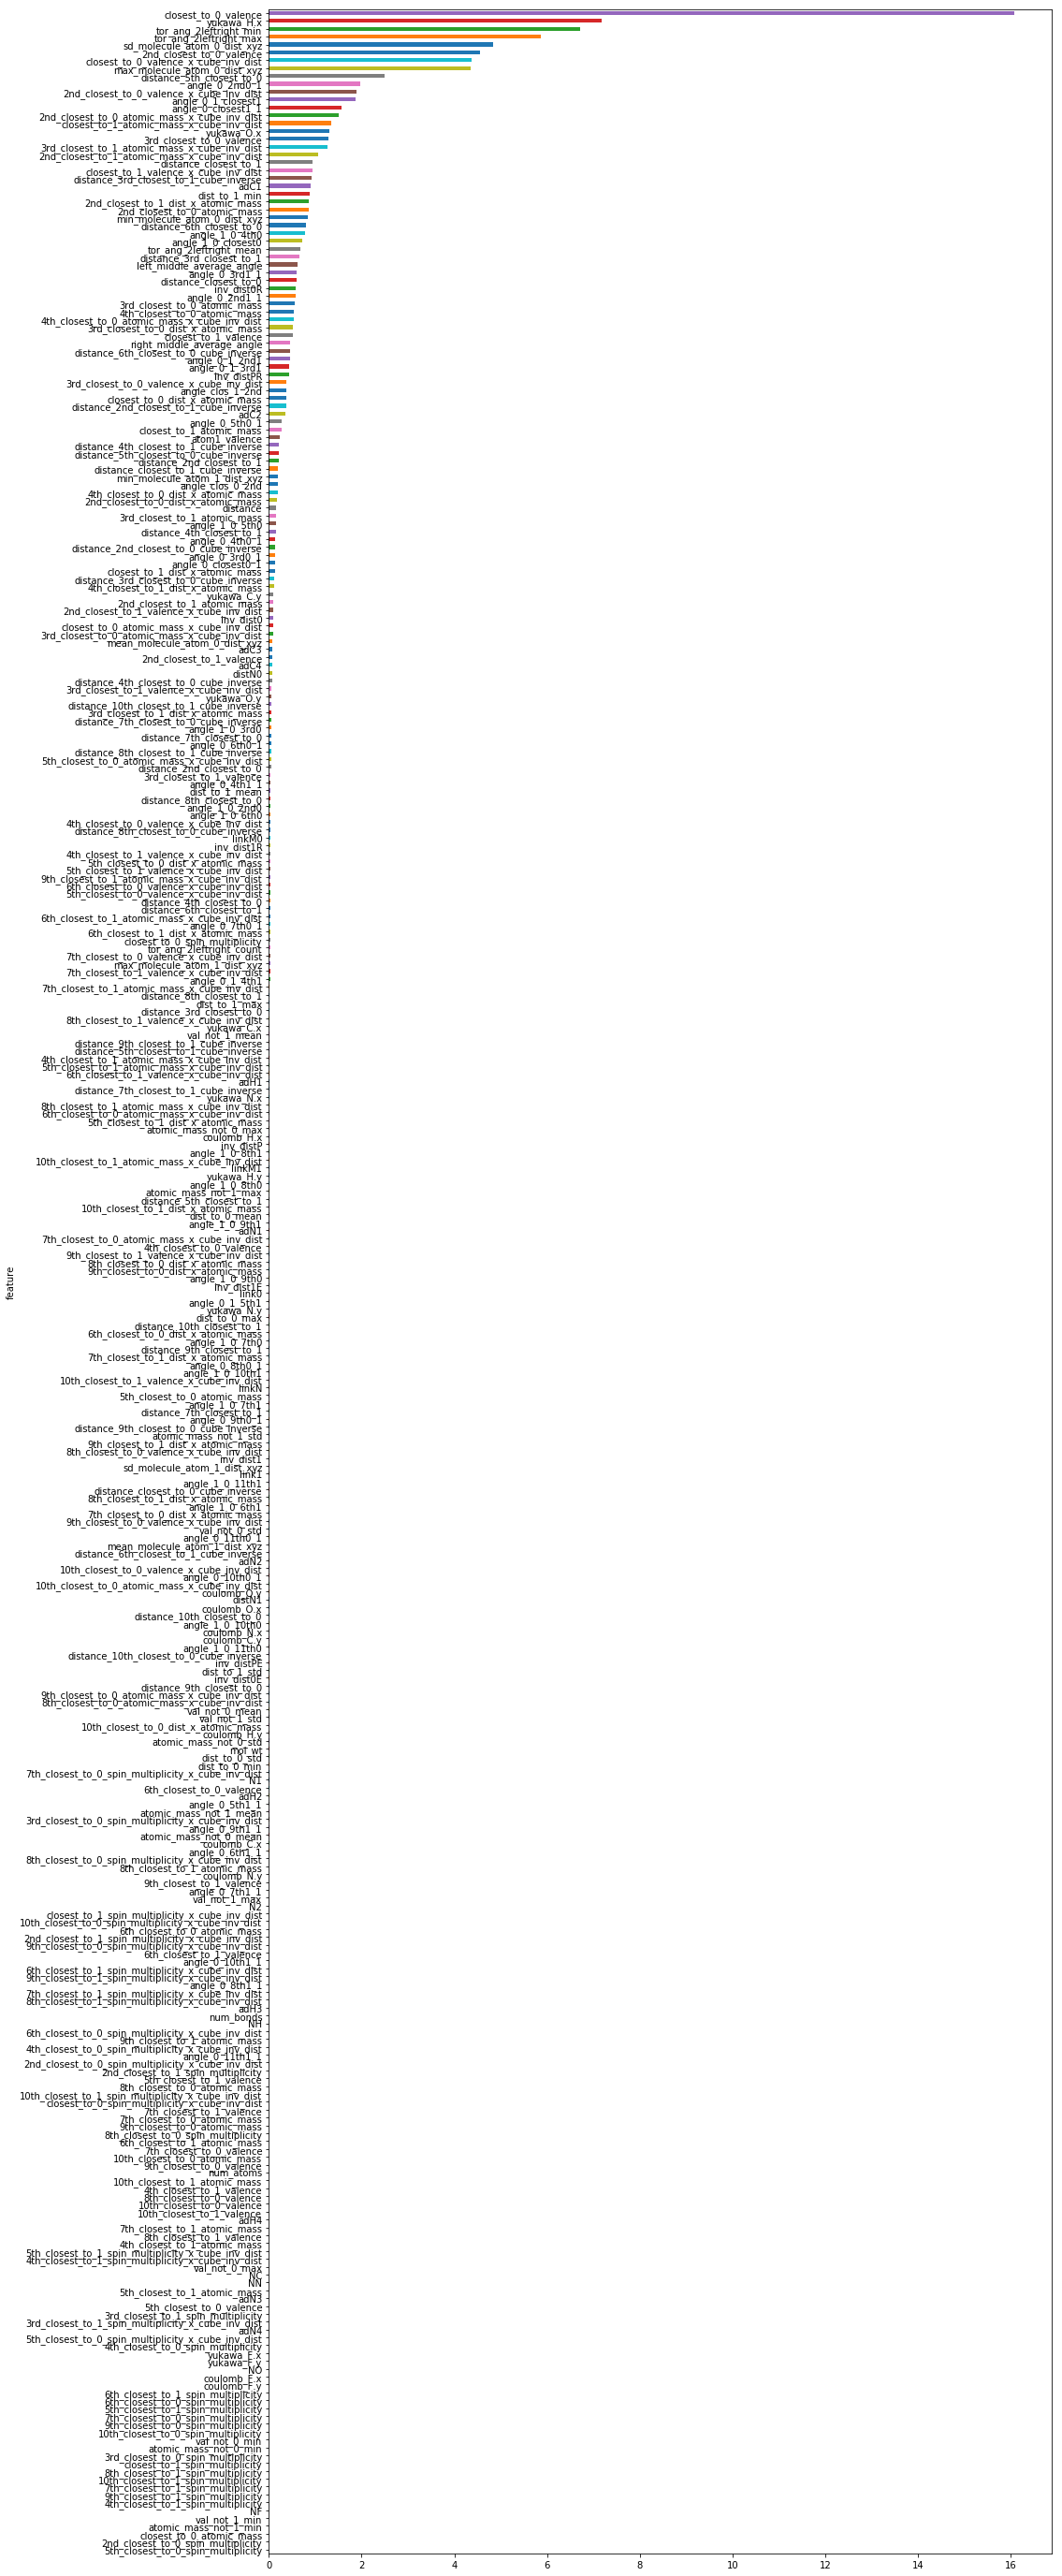

In [8]:
t = '2JHN'
fi.loc[fi['type'] == t].groupby('feature').mean().sort_values('importance')['importance'].plot(kind='barh', figsize=(15, 50))

In [ ]:
def permutation_importance(model, X_val, y_val, metric, t, threshold=0.005,
                           minimize=True, verbose=True, thread_count=16):
    """
    Reference: https://www.kaggle.com/speedwagon/permutation-importance
    
    Modified by Rob
    """
    results = {}
    
    y_pred = model.predict(X_val, thread_count=thread_count)
    
    results['base_score'] = metric(y_val, y_pred)
    if verbose:
        print(f'Base score {results["base_score"]:.5}')

    feature_list = fi.loc[fi['type'] == t].groupby('feature').mean().sort_values('importance').index.tolist()
    for col in tqdm(feature_list):
        freezed_col = X_val[col].copy()

        X_val[col] = np.random.permutation(X_val[col])
        preds = model.predict(X_val, thread_count=thread_count)
        results[col] = metric(y_val, preds)
        if results[col] > results['base_score'] + threshold:
            print('Stopping because first feature has reached the threshold')
            break
        X_val[col] = freezed_col
        
        if verbose:
            print(f'column: {col} - {results[col]:.5}')
    
    if minimize:
        bad_features = [k for k in results if results[k] < results['base_score'] + threshold]
    else:
        bad_features = [k for k in results if results[k] > results['base_score'] + threshold]
    bad_features.remove('base_score')
    
    return results, bad_features

In [ ]:
types = ['3JHC', '2JHN', '1JHN', '3JHN', '2JHH', '2JHC', '3JHH', '1JHC']
MODEL_NUMBER = 'M042'
FE_NUMBER = 'FE017'
results_dict = {}
bad_features_dict = {}
for t in types:
    print(f'Running for {t}')
    train = pd.read_parquet(f'../data/{FE_NUMBER}/{FE_NUMBER}-train-{t}.parquet')
    x = pd.read_parquet('../data/FE008_train.parquet') # only loading for skeleton not features
    model = catboost.CatBoostRegressor()
    model.load_model(f'../models/{MODEL_NUMBER}/{MODEL_NUMBER}-0709_1336-{t}-1.model')
    print('Model loaded')
    mol_group = x[['molecule_name','type']].copy()
    N_FOLDS = 2
    folds = GroupKFold(n_splits=N_FOLDS)
    X = train[model.feature_names_]
    y = train['scalar_coupling_constant']
    mol_group_type = mol_group.loc[mol_group['type'] == t]['molecule_name']
    for fold_n, (train_idx, valid_idx) in enumerate(folds.split(X, groups=mol_group_type)):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        X_valid = X_valid.copy()
        results, bad_features = permutation_importance(model, X_valid, y_valid, metric=mean_absolute_error, t=t)
        results_dict[t] = results
        bad_features_dict[t] = bad_features
        break # Only run for the first fold
    print(f'Bad features for {t}:')
    print(bad_features)
    del train, x, X, y, mol_group_type
    gc.collect()

Running for 3JHC
Model loaded


  0%|          | 0/318 [00:00<?, ?it/s]

Base score 0.24577


  0%|          | 1/318 [01:49<9:40:05, 109.80s/it]

column: closest_to_0_atomic_mass - 0.24577


  1%|          | 2/318 [03:48<9:51:48, 112.37s/it]

column: val_not_1_min - 0.24577


  1%|          | 3/318 [05:35<9:42:35, 110.97s/it]

column: atomic_mass_not_1_min - 0.24577


  1%|▏         | 4/318 [07:16<9:25:13, 108.00s/it]

column: NF - 0.24577


  2%|▏         | 5/318 [08:57<9:11:42, 105.76s/it]

column: 10th_closest_to_0_spin_multiplicity - 0.24577


  2%|▏         | 6/318 [10:38<9:03:13, 104.47s/it]

column: val_not_0_min - 0.24577


  2%|▏         | 7/318 [12:21<8:59:16, 104.04s/it]

column: 9th_closest_to_1_spin_multiplicity - 0.24577


  3%|▎         | 8/318 [14:00<8:48:38, 102.32s/it]

column: 8th_closest_to_1_spin_multiplicity - 0.24577


  3%|▎         | 9/318 [15:38<8:41:15, 101.22s/it]

column: 7th_closest_to_1_spin_multiplicity - 0.24577


  3%|▎         | 10/318 [17:24<8:45:55, 102.45s/it]

column: atomic_mass_not_0_min - 0.24577


  3%|▎         | 11/318 [19:12<8:53:07, 104.20s/it]

column: 5th_closest_to_1_spin_multiplicity - 0.24577


  4%|▍         | 12/318 [20:56<8:51:27, 104.21s/it]

column: 8th_closest_to_0_spin_multiplicity - 0.24577


  4%|▍         | 13/318 [22:43<8:53:16, 104.91s/it]

column: 6th_closest_to_1_spin_multiplicity - 0.24577


  4%|▍         | 14/318 [24:25<8:47:57, 104.20s/it]

column: 4th_closest_to_1_spin_multiplicity - 0.24577


  5%|▍         | 15/318 [26:06<8:41:21, 103.24s/it]

column: 6th_closest_to_0_spin_multiplicity - 0.24577
